Welcome to the more powerful fitting tool in of the 2. it requires more manual input, but gets very good optimization.
To show how it can be used yourself, we load in some data, and fit that with the program

In [1]:
#imports
import pandas as pd
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
import random
import progressbar

In [2]:
# load in and read your data, see 'CSVs' for the datasets.
# The format is important it needs a column called 'time', and the names of species are taken form the header

# In this example i have data from 9 runs, 3 temperatures, 3 initial conditions.
data_323_1_1 = pd.read_csv('CSVs/sim_kinetics_323_1_1.csv')
data_323_1_1 = data_323_1_1.drop('Unnamed: 0', axis=1)

data_323_4_2 = pd.read_csv('CSVs/sim_kinetics_323_4_2.csv')
data_323_4_2 = data_323_4_2.drop('Unnamed: 0', axis=1)

data_323_8_1p5 = pd.read_csv('CSVs/sim_kinetics_323_8_1.5.csv')
data_323_8_1p5 = data_323_8_1p5.drop('Unnamed: 0', axis=1)

data_363_1_1 = pd.read_csv('CSVs/sim_kinetics_363_1_1.csv')
data_363_1_1 = data_363_1_1.drop('Unnamed: 0', axis=1)

data_363_4_2 = pd.read_csv('CSVs/sim_kinetics_363_4_2.csv')
data_363_4_2 = data_363_4_2.drop('Unnamed: 0', axis=1)

data_363_8_1p5 = pd.read_csv('CSVs/sim_kinetics_363_8_1.5.csv')
data_363_8_1p5 = data_363_8_1p5.drop('Unnamed: 0', axis=1)

data_393_1_1 = pd.read_csv('CSVs/sim_kinetics_393_1_1.csv')
data_393_1_1 = data_393_1_1.drop('Unnamed: 0', axis=1)

data_393_4_2 = pd.read_csv('CSVs/sim_kinetics_393_4_2.csv')
data_393_4_2 = data_393_4_2.drop('Unnamed: 0', axis=1)

data_393_8_1p5 = pd.read_csv('CSVs/sim_kinetics_393_8_1.5.csv')
data_393_8_1p5 = data_393_8_1p5.drop('Unnamed: 0', axis=1)

data_list = [data_323_1_1,data_323_4_2,data_323_8_1p5,
            data_363_1_1,data_363_4_2,data_363_8_1p5,
            data_393_1_1,data_393_4_2,data_393_8_1p5,] # bundle all the data together convenienely
new_list = []
for data in data_list:
    new_list.append(data.rename(columns={" A2":"A2"}))

data_list = new_list

In [3]:
# Your input should look like this
data_323_1_1

,time,E,A1,A2,tE
0,0.00,1.006003,0.008713,-0.014507,0.006901
1,1.46,1.001466,0.006796,0.001496,0.004849
2,3.46,0.935757,0.021772,0.019463,0.015240
3,5.46,1.000443,0.048656,0.023227,-0.007172
4,7.46,0.971885,0.037763,0.059452,-0.005370
5,9.46,1.021070,0.040190,0.055805,-0.010169
6,11.46,0.971248,0.050642,0.067279,0.017205
7,13.46,0.971808,0.083881,0.079541,0.015972
8,15.46,0.933314,0.055635,0.091039,0.004599
9,19.46,0.894704,0.084134,0.109694,-0.007973


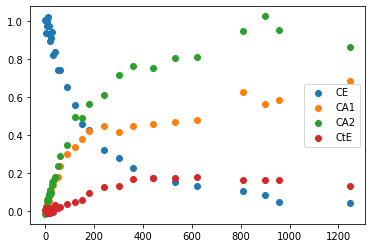

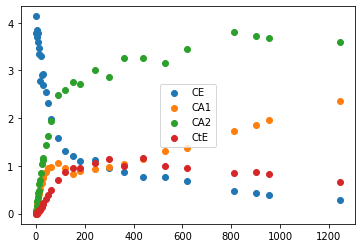

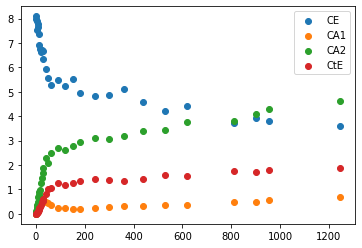

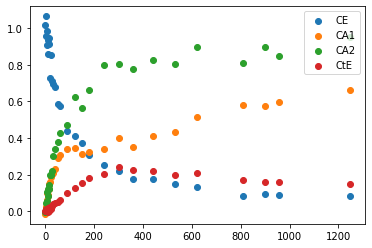

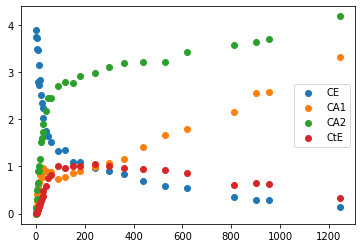

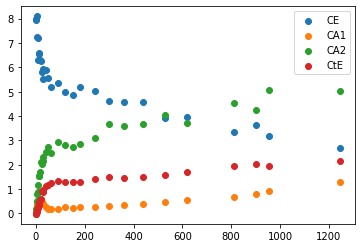

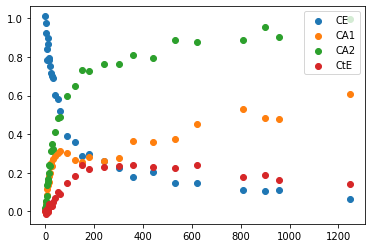

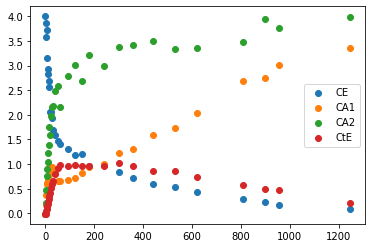

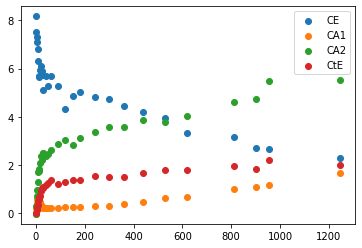

In [4]:
# Let's check what we have
for data in data_list:
    plt.figure()
    plt.scatter(data['time'],data['E'], label ='CE')
    plt.scatter(data['time'],data['A1'], label ='CA1')
    plt.scatter(data['time'],data['A2'], label ='CA2')
    plt.scatter(data['time'],data['tE'], label ='CtE')
    plt.legend()

Here follow all the functions with comments what they do

In [5]:
def change_coord(data,names):
    "Changes the concentration vs time values to the rate vs time values for more precise fitting"
    for dataset in data:
        for name in names:
            rate_list = []
            for i in range(len(dataset[name])-1):
                rate_list.append((dataset[name][i+1]-dataset[name][i])/(dataset['time'][i+1]-dataset['time'][i])) 
            dataset[f'{name}_rate'] = rate_list
    return data

In [6]:
def get_r2(real,simul, names):
    "Convenient function for getting the errors of out simulations compared to our data"
    total = 0
    for name in names:
        total += r2_score(real[name], simul[name]) + r2_score(real[f'{name}_rate'], simul[f'{name}_rate'])
    return total

In [7]:
def fit_sim(diff, data, names, rates, iterations =1000):
    "Program for fitting single data runs, or multiple runs bundled per temperature"
    max_score = len(data)*len(names)*2 # Max score is automatically calculated
    bar = progressbar.ProgressBar(max_value=iterations) # For tracking progress
    progress = []
    def residual(paras):
        """
        compute the residual between actual data and fitted data
        """
        subject = {rate: paras[rate].value for rate in rates} #bundle all the parameters
        score = 0
        
        for dataset in data: #for all provided data we make a comparison
            sim_dict = {} #dictionary to get the simulation in the same format as the provided data
            sol = integrate.solve_ivp(diff, [0,dataset['time'][-1]], dataset['init'], args = (subject,), t_eval = dataset['time']) #run the optimization with the conditions in the data and the rate constant estimates
            sim_dict['time'] = list(sol.t)
            for count,name in enumerate(names):
                sim_dict[name] = list(sol.y[count]) #Store all the data in the dictionary
            sim_dict = change_coord([sim_dict],names) #Get rate profiles
            score += get_r2(dataset,sim_dict[0], names) # Keep track of score
        score_list = [max_score-score for i in range(len(subject))]
        
        if len(progress) < iterations: # progress the progress bar
            progress.append(0)
            bar.update(len(progress))
        
        return score_list

    

    # set parameters including bounds
    params = Parameters() # make a parameter list that the program will vary to optimize
    for rate in rates:
        params.add(rate, value=0.01, min=1e-10, max=1) #for all rates make and estimate, make sure initial condtions are tuned to keep within these bounds
    #bounds can be changed, but rates higher than 1 can make the differential solver slow, it is better to correct for the changed initial conditons at the end

    results = minimize(residual, params, method='leastsq', max_nfev = iterations) #minimize the difference between the real data and the simulations by tuning the rates

    fin_sub = {rate: results.params[rate].value for rate in rates} #to check and plot results
    
    score = 0 # same as the function in residual, but with the final parameters
    final_list = []
    for dataset in data:
        final_dict = {}
        final_sol = integrate.solve_ivp(diff, [0,dataset['time'][-1]], dataset['init'], args = (fin_sub,), t_eval = dataset['time'])
        final_dict['time'] = list(final_sol.t)
        for count,name in enumerate(names):
            final_dict[name] = list(final_sol.y[count])
        final_dict = change_coord([final_dict],names)
        final_list.append(final_dict[0])
        score += get_r2(dataset,final_dict[0],names)


    # plot fitted data and original data
    
    for count, dataset in enumerate(data):
        plt.figure()
        for name in names:
            plt.scatter(dataset['time'], dataset[name], marker = 'o', label = f'real data {name}')
            plt.plot(final_list[count]['time'], final_list[count][name], label = f'sim data {name}')
        plt.legend()
        plt.title(f"plot for T: {dataset['T']}, init: {dataset['init']}")
    # display fitted statistics
    print(f"score is {score} out of {max_score} for T: {data[0]['T']}")
    report_fit(results)
    
    return results.params

In [8]:
def fit_sim_full(diff, data, names, rates,guesses, temperatures, iterations =1000):
    "Program for fitting data across different temperatures simultaneously"
    max_score = len(data)*len(names)*2
    R = 8.314
    bar = progressbar.ProgressBar(max_value=iterations)
    progress = [] 
    def residual(paras):
        """
        compute the residual between actual data and fitted data
        """
        base_subject = {}
        for rate in rates: #the rates are now deconstructed to make sure they can vary between temperatures
            base_subject[f'E{rate[1:]}'] = paras[f'E{rate[1:]}'].value
            base_subject[rate] = paras[rate].value
        for rate in rates: # if the value is greater the optimization is slow
            if base_subject[rate] >1:
                score = [max_score for i in range(len(paras))]
                return score
            
        subjects = {} #now for every temperature we store the resulting rates, given the estimated activation energies
        for temp in temperatures:
            subject = {rate: base_subject[rate]*(np.exp((-base_subject[f'E{rate[1:]}']/R)*(1/temp-1/max(temperatures))))
                      for rate in rates} #rate = base rate* e^(E_act estimate/R * ratio between temperatures)
            subjects[temp] = subject #store rates for each temperatures

        score = 0
        for dataset in data: #for all data we make a comparison
            sim_dict = {}
            subject = subjects[dataset['T']] #get the right resultant rates based on the temperature of this data run
            sol = integrate.solve_ivp(diff, [0,dataset['time'][-1]], dataset['init'], args = (subject,), t_eval = dataset['time']) #simulate run based on those rates
            sim_dict['time'] = list(sol.t) #from here it is the same as the base fitting
            for count,name in enumerate(names):
                sim_dict[name] = list(sol.y[count])
            sim_dict = change_coord([sim_dict],names)
            score += get_r2(dataset,sim_dict[0], names)
        score_list = [max_score-score for i in range(len(paras))]
        
        if len(progress) < iterations:
            progress.append(0)
            bar.update(len(progress))
        
        return score_list



    # set parameters including bounds
    params = Parameters()
    for num, rate in enumerate(rates): #to fit across temperatures we now estimate not only the rate but also the activation energy
        params.add(f'E{rate[1:]}', value=guesses[0,num], min=1000, max=100000)
        params.add(rate, value=guesses[1,num], min=1e-5, max=1e5)



    # fit model
    results = minimize(residual, params, method='leastsq', max_nfev = iterations) 
    
    #from here again we do a last simulation and plot of the final estimates by doing what is happening in the 'residual' function.
    fin_base_subject = {}
    for rate in rates:
        fin_base_subject[f'E{rate[1:]}'] = results.params[f'E{rate[1:]}'].value
        fin_base_subject[rate] = results.params[rate].value
    for rate in rates:
        if fin_base_subject[rate] >1:
            score = [max_score for i in range(len(paras))]
            return score

    fin_subjects = {}
    for temp in temperatures:
        fin_subject = {rate: fin_base_subject[rate]*(np.exp((-fin_base_subject[f'E{rate[1:]}']/R)*(1/temp-1/max(temperatures))))
                  for rate in rates}    
        fin_subjects[temp] = fin_subject
    
    score = 0
    final_list = []
    for dataset in data:
        final_dict = {}
        fin_subject = fin_subjects[dataset['T']]
        final_sol = integrate.solve_ivp(diff, [0,dataset['time'][-1]], dataset['init'], args = (fin_subject,), t_eval = dataset['time'])
        final_dict['time'] = list(final_sol.t)
        for count,name in enumerate(names):
            final_dict[name] = list(final_sol.y[count])
        final_dict = change_coord([final_dict],names)
        final_list.append(final_dict[0])
        score += get_r2(dataset,final_dict[0], names)
    
    # check results of the fit
    for count, dataset in enumerate(data):
        plt.figure()
        for name in names:
            plt.scatter(dataset['time'], dataset[name], marker = 'o', label = f'real data {name}')
            plt.plot(final_list[count]['time'], final_list[count][name], label = f'sim data {name}')
        plt.legend()
        plt.title(f"plot for T: {dataset['T']}, init: {dataset['init']}")
    # display fitted statistics 
    print(f"score is {score} out of {max_score}")
    report_fit(results)
    

    
    return results.params
    

In [9]:
def data_formatting(data, temperatures, initial_conditions = None):
    "Function to put data in a format the functions can easily handle"
    total_dicts = []
    for i in range(len(data)):
        data_dict = {} #make a dictionary out of the dataframe
        for column in data[i].columns:
            data_dict[column] = list(data[i][column]) #store the measured concentrations
        data_dict['T'] = temperatures[i] #store the temperatures
        data_dict['init'] = initial_conditions[i] #store the initial conditions
        total_dicts.append(data_dict) #put it all together
    return total_dicts
        

In [10]:
class fitting_set:
    "Class to keep track of a fitting experiment run"
    def __init__(self,system,data,temperatures, initial_conditions, rates):
        "Get all the inital parameters, and format the,"
        self.system = system
        self.temperatures = sorted(set(temperatures))
        self.data = data_formatting(data, temperatures, initial_conditions)
        keys = self.data[0].keys()
        unwanted = ['time', 'T', 'init']
        self.species_names = [key for key in keys if key not in unwanted] #names for the plots
        self.data = change_coord(self.data,self.species_names) #get rate graphs
        self.rates = rates #for naming the rates in the evaluation
        self.rates_dict = {rate:[] for rate in self.rates} #dictionart for making the activation energies later
        self.rates_dict['temp'] = []
        

        
    def fit_sys(self,data_num, iterations):
        "Function for fitting a single data run, useful for quick checks"
        fit_sim(self.system, [self.data[data_num]], self.species_names, self.rates, iterations)
        
     

    def fit_sys_all(self,iterations):
        "Function for fitting all the data per temperature, the accuracy is increased because of the parallel fitting"
        self.max_temp_vals = []
        for temp in self.temperatures: #for each temperature
            indices = []
            for i in range(len(self.data)):
                if self.data[i]['T'] == temp: #get all runs with that temperature
                    indices.append(i)
            to_run = [self.data[i] for i in indices] #filter them from the big dataset
            fits = fit_sim(self.system, to_run, self.species_names, self.rates, iterations) #fit them in parallel
            self.rates_dict['temp'].append(temp) #for this temperature
            for rate in self.rates:
                self.rates_dict[rate].append(fits[rate].value) #store all the values for the rates
                if temp == max(self.temperatures): #if it is the maximal temperature
                    self.max_temp_vals.append(fits[rate].value) #also make a list of the rates
        
    def kin_params_guesses(self):
        "Guess the activation energies and Arrhenius pre constants fomr the relation of temperatures and rate constants"
        self.Eact_list = []
        self.A_list = []
        to_run = dict(self.rates_dict.items())
        del to_run['temp'] #make sure we only evaluate the rate results
        for variable,lis in to_run.items():
            log_list = np.log(lis) #change the values to get a linear relationship
            reciprocal_list = 1/np.array(self.rates_dict['temp'])
            lin_model = np.polyfit(reciprocal_list,log_list,1) #make a linear fit
            slope = lin_model[0] #get the slope and y-axis intercept
            intercept = lin_model[1]
            self.Eact_list.append(slope*8.314) #construct the kinetic parameters from the fit
            self.A_list.append(np.exp(intercept))
        
    def fit_sys_full(self, iterations):
        "For the parallel fitting across temperatures with the guesses we made for the activation energies"
        self.kin_params_guesses() #guess the simulation starting point
        guesses = np.zeros([2,len(self.rates)])
        guesses[0,:] = self.Eact_list #store the inital guesses for the rates at the highest temperature and for the activation energies
        guesses[0,:] *= -1
        guesses[1,:] = self.max_temp_vals
        for guess in guesses[0,:]: #make sure it is not outside of the bounds
            if guess <1000:
                guess = 1000
        fits = fit_sim_full(self.system, self.data, self.species_names, self.rates, guesses, self.temperatures, iterations) #fit the data
        final_data = {} #dictionary to make a final evaluation
        R = 8.314
        final_data['rate'] = self.rates #we make a table with rates
        final_data['E_act'] = [] #activation energies
        final_data[f'T={max(self.temperatures)}'] = [] #rates at the maximmum temperature
        for rate in self.rates:
            final_data['E_act'].append(fits[f'E{rate[1:]}'].value)
            final_data[f'T={max(self.temperatures)}'].append(fits[rate].value)
        final_data['Arrhenius constant'] = list(np.array(final_data[f'T={max(self.temperatures)}'])/(np.exp(-np.array(final_data['E_act'])/(max(self.temperatures)*R)))) #activation energies
        for temp in self.temperatures:
            final_data[f'T={temp}'] = list(np.array(final_data[f'T={max(self.temperatures)}'])*(np.exp((-np.array(final_data['E_act'])/R)*(1/temp-1/max(self.temperatures))))) #rates at all temperatures
        final_table = pd.DataFrame(final_data)
        return final_table
                
            
        
        

In [11]:
def diff(x, init, rate_const):
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead = init
    k1, k2f, k2b, k3, k4, k5= rate_const['k1'],rate_const['k2f'],rate_const['k2b'],rate_const['k3'],rate_const['k4'],rate_const['k5']
#         k1,k2f,k2b,k3,k4,k5 = rate_const
    dEdt = -k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2
    dA1dt = k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2 + 2*k3*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2f*CE*CA1 - k2b*CtE*CA2
    dtEdt = k2f*CE*CA1 - k2b*CtE*CA2 - k3*CtE*Cprecat
    dprecatdt = -k1*CE*Cprecat - k3*CtE*Cprecat + k4*Ccat*0.04 - k5*Cprecat
    dcatdt = k1*CE*Cprecat + k3*CtE*Cprecat - k4*Ccat*0.04
    dcatdeaddt = k5*Cprecat
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt

In [14]:
# we have a list of our data made, now we just need to put in the conditions for each run so the differential can work with them.
data = data_list
temperatures = [323,323,323,363,363,363,393,393,393] #temperatures of each dataset, in order of the datasets
initial_conditions = [[1,0,0,0,1,0,0],[4,0,0,0,2,0,0],[8,0,0,0,1.5,0,0],
                      [1,0,0,0,1,0,0],[4,0,0,0,2,0,0],[8,0,0,0,1.5,0,0],
                      [1,0,0,0,1,0,0],[4,0,0,0,2,0,0],[8,0,0,0,1.5,0,0],]#initial conditions of each dataset, in order of the datasets
                      
rates = ['k1','k2f','k2b','k3','k4','k5'] #name all the rates you will use
test = fitting_set(diff,data,temperatures,initial_conditions, rates) #and instantiate the class so we can keep track
#by using the class it is easier to do multiple fits in one document

For more accurate results set the iterations of all the runs to 1000 or higher, for speed it is nice to keep it at 100

 98% (98 of 100) |###################### | Elapsed Time: 0:00:00 ETA:   0:00:00

score is 6.280377016502479 out of 8 for T: 363
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 6
    # variables        = 6
    chi-square         = 17.7426192
    reduced chi-square = 17.7426192
    Akaike info crit   = 18.5052609
    Bayesian info crit = 17.2558177
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:   0.01152243 (init = 0.01)
    k2f:  0.01426219 (init = 0.01)
    k2b:  0.00398152 (init = 0.01)
    k3:   0.07397068 (init = 0.01)
    k4:   0.02537727 (init = 0.01)
    k5:   0.00711562 (init = 0.01)


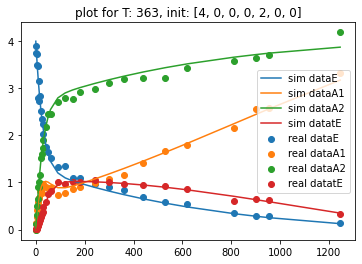

In [16]:
#lets test the algorithm for our fitfth graph, it is very fast, and the fits are tight
test.fit_sys(4, iterations = 100)

  8% (8 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:01

score is 17.04061560756257 out of 24 for T: 323
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 6
    # variables        = 6
    chi-square         = 290.598187
    reduced chi-square = 290.598187
    Akaike info crit   = 35.2810923
    Bayesian info crit = 34.0316491
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:   0.00580067 (init = 0.01)
    k2f:  0.00981850 (init = 0.01)
    k2b:  0.00325221 (init = 0.01)
    k3:   0.06862805 (init = 0.01)
    k4:   0.01686565 (init = 0.01)
    k5:   0.00517477 (init = 0.01)


  9% (9 of 100) |##                      | Elapsed Time: 0:00:00 ETA:   0:00:01

score is 17.119265116571537 out of 24 for T: 363
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 6
    # variables        = 6
    chi-square         = 284.067075
    reduced chi-square = 284.067075
    Akaike info crit   = 35.1447055
    Bayesian info crit = 33.8952623
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:   0.01146714 (init = 0.01)
    k2f:  0.01393794 (init = 0.01)
    k2b:  0.00393046 (init = 0.01)
    k3:   0.04818840 (init = 0.01)
    k4:   0.03186766 (init = 0.01)
    k5:   0.00927885 (init = 0.01)


 99% (99 of 100) |###################### | Elapsed Time: 0:00:03 ETA:   0:00:00

score is 18.06200145956288 out of 24 for T: 393
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 6
    # variables        = 6
    chi-square         = 211.558960
    reduced chi-square = 211.558960
    Akaike info crit   = 33.3764656
    Bayesian info crit = 32.1270224
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:   0.01931048 (init = 0.01)
    k2f:  0.01857129 (init = 0.01)
    k2b:  0.00526952 (init = 0.01)
    k3:   0.07458745 (init = 0.01)
    k4:   0.04458896 (init = 0.01)
    k5:   0.02034752 (init = 0.01)


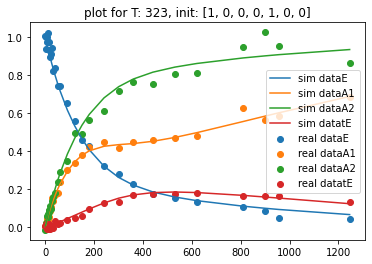

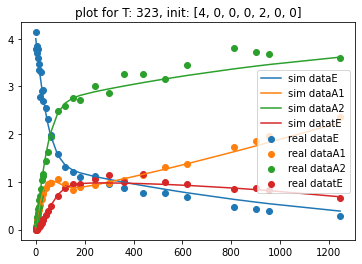

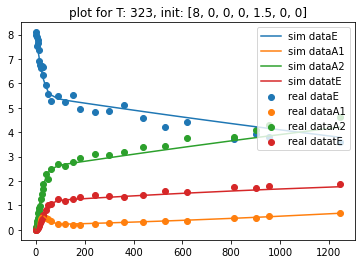

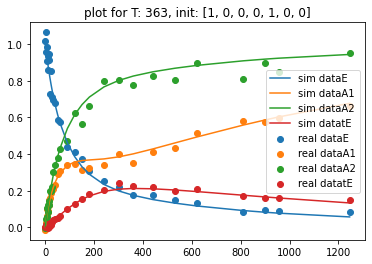

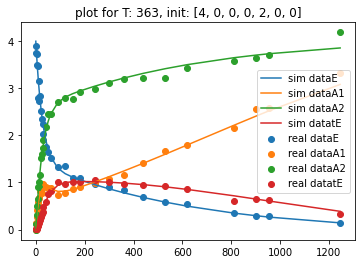

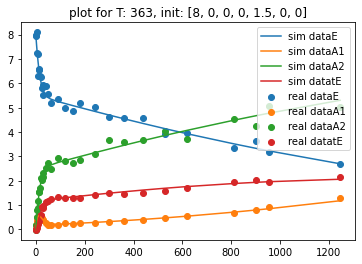

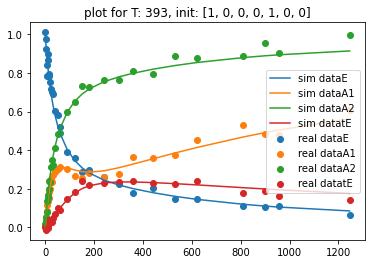

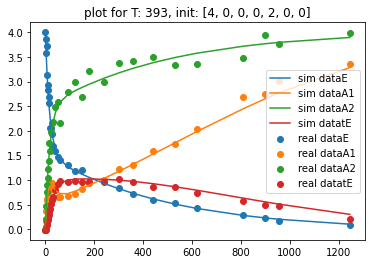

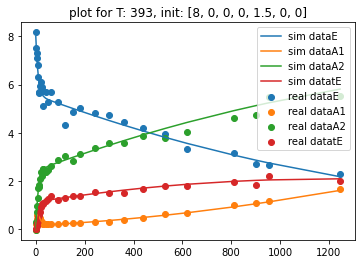

In [18]:
#now let's fit all of the data per temperature and see how accurate out guesses are
test.fit_sys_all(iterations = 100) #if you want to check the values, all values can be found in the document 'Chemfit_example_from_research'
#again good fits. let's see if that means we can combine this to get the activation energied and Arrhenius pre constants

 99% (99 of 100) |###################### | Elapsed Time: 0:00:11 ETA:   0:00:00

score is 52.27593571101098 out of 72
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 12
    # variables        = 12
    chi-square         = 4668.46454
    reduced chi-square = 4668.46454
    Akaike info crit   = 95.5641463
    Bayesian info crit = 101.383026
##  Warning: uncertainties could not be estimated:
    E3:   at initial value
    E3:   at boundary
[[Variables]]
    E1:   18006.7302 (init = 17986)
    k1:   0.01900059 (init = 0.01931048)
    E2f:  9662.23127 (init = 9506.231)
    k2f:  0.01884466 (init = 0.01857129)
    E2b:  7959.69546 (init = 7020.557)
    k2b:  0.00522361 (init = 0.005269516)
    E3:   1000.00000 (init = 1000)
    k3:   0.07640623 (init = 0.07458745)
    E4:   14412.3209 (init = 14739.3)
    k4:   0.04504921 (init = 0.04458896)
    E5:   20407.6827 (init = 20026.54)
    k5:   0.02012985 (init = 0.02034752)


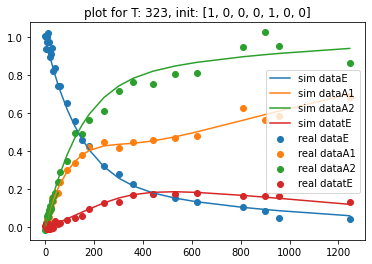

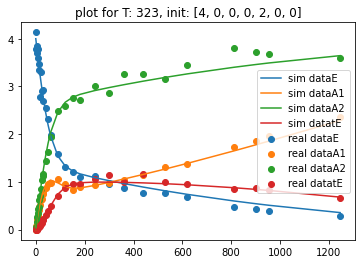

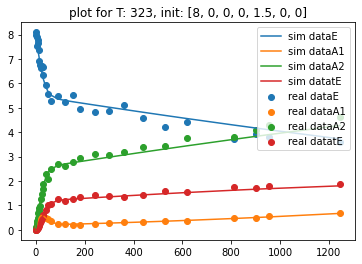

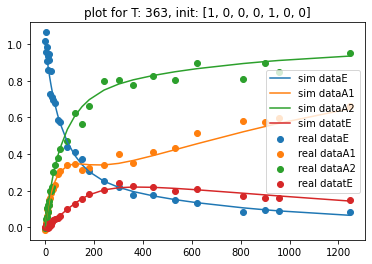

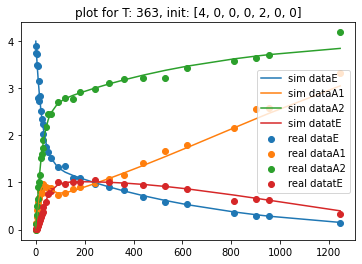

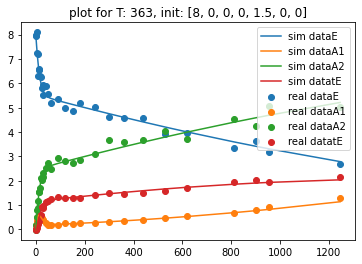

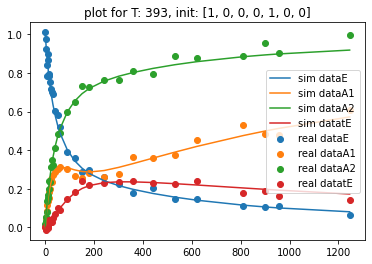

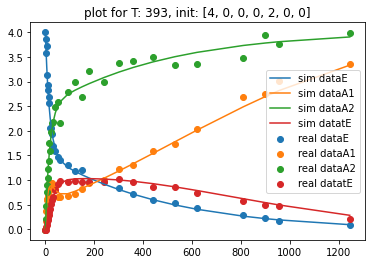

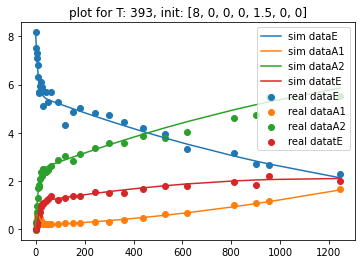

In [19]:
#now we fit all the data in parallel
result = test.fit_sys_full(iterations = 100)
#the run changed the data very little, but it is important to check it's consistency, and if the estimates are worse the optimization changes it for the better
#if the runs for estimates are run at 100 iterations and this is run at 1000 the effect is clearer

In [20]:
frame = display(result) #final results

,rate,E_act,T=393,Arrhenius constant,T=323,T=363
0,k1,18006.730164,0.019001,4.700828,0.005755,0.012049
1,k2f,9662.231275,0.018845,0.362632,0.009928,0.014759
2,k2b,7959.695465,0.005224,0.059697,0.003081,0.004271
3,k3,1000.000000,0.076406,0.103764,0.071503,0.074498
4,k4,14412.320928,0.045049,3.709667,0.017319,0.031287
5,k5,20407.682727,0.020130,10.384272,0.005200,0.012013
